# Introduction to Geopandas

In this lesson, we will cover basics steps needed for interacting with spatial data in Python using geopandas:

- Managing filepaths
- Reading spatial data from file 
- Geometry calculations 
- Writing spatial data to file
- Grouping and splitting spatial data into multiple layers


Geopandas (http://geopandas.org/) makes it possible to work with geospatial data in Python in a relatively easy way. Geopandas combines the capabilities of the data analysis library [pandas](https://pandas.pydata.org/pandas-docs/stable/) with other packages like [shapely](https://shapely.readthedocs.io/en/stable/manual.html) and [fiona](https://fiona.readthedocs.io/en/latest/manual.html) for managing spatial data. 

The main data structures in geopandas are `GeoSeries` and `GeoDataFrame` which extend the capabilities of `Series` and `DataFrames` from pandas. This means that we can use all our pandas skills also when working with geopandas!  If you need to refresh your memory about pandas, check out week 5 and 6 lesson materials from the [Geo-Python website](geo-python.github.io). 

The main difference between geodataframes and pandas dataframes is that a [geodataframe](http://geopandas.org/data_structures.html#geodataframe) should contain one column for geometries. By default, the name of this column is `'geometry'`. The geometry column is a [geoseries](http://geopandas.org/data_structures.html#geoseries) which contains the geometries (points, lines, polygons, multipolygons etc.) as shapely objects. 

![geodataframe.png](img/geodataframe.png)

As we learned in the Geo-Python course, it is conventional to import pandas as `pd`. Similarly,we will import geopandas as `gpd`:

In [1]:
import geopandas as gpd

/home/aagesenh/.conda/envs/python-gis/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Input data: Finnish topographic database 

In this lesson we will work with the [National Land Survey of Finland (NLS) topographic database (from 2018)](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/expert-users/product-descriptions/topographic-database). 
- The data set is licensed under the NLS' [open data licence](https://www.maanmittauslaitos.fi/en/opendata-licence-cc40) (CC BY 4.0).
- Structure of the data is described in a separate Excel file ([download link](http://www.maanmittauslaitos.fi/sites/maanmittauslaitos.fi/files/attachments/2018/10/maastotietokanta_kohdemalli_eng.xlsx)).
- Further information about file naming is available at [fairdata.fi](https://etsin.fairdata.fi/dataset/5023ecc7-914a-4494-9e32-d0a39d3b56ae).

For this lesson, we have acquired a subset of the topographic database as shapefiles from the Helsinki Region in Finland via the [CSC open data portal](https://avaa.tdata.fi/web/paituli/latauspalvelu):

![Paituli data download](img/Paituli_maastotietokanta_download.png)


In this lesson, we will focus on **terrain objects** (Feature group: "Terrain/1" in the topographic database). The Terrain/1 feature group contains several feature classes. **Our aim in this lesson is to save all the Terrain/1 feature classes into separate files**.

*Terrain/1 features in the Topographic Database:*

|  feature class | Name of feature                                            | Feature group |
|----------------|------------------------------------------------------------|---------------|
| 32421          | Motor traffic area                                         | Terrain/1     |
| 32200          | Cemetery                                                   | Terrain/1     |
| 34300          | Sand                                                       | Terrain/1     |
| 34100          | Rock - area                                                | Terrain/1     |
| 34700          | Rocky area                                                 | Terrain/1     |
| 32500          | Quarry                                                     | Terrain/1     |
| 32112          | Mineral resources extraction area, fine-grained material   | Terrain/1     |
| 32111          | Mineral resources extraction area, coarse-grained material | Terrain/1     |
| 32611          | Field                                                      | Terrain/1     |
| 32612          | Garden                                                     | Terrain/1     |
| 32800          | Meadow                                                     | Terrain/1     |
| 32900          | Park                                                       | Terrain/1     |
| 35300          | Paludified land                                            | Terrain/1     |
| 35412          | Bog, easy to traverse forested                             | Terrain/1     |
| 35411          | Open bog, easy to traverse treeless                        | Terrain/1     |
| 35421          | Open fen, difficult to traverse treeless                   | Terrain/1     |
| 33000          | Earth fill                                                 | Terrain/1     |
| 33100          | Sports and recreation area                                 | Terrain/1     |
| 36200          | Lake water                                                 | Terrain/1     |
| 36313          | Watercourse area                                           | Terrain/1     |


According to the [naming convention](https://etsin.fairdata.fi/dataset/5023ecc7-914a-4494-9e32-d0a39d3b56ae), all files that start with a letter `m` and end with `p` contain the objects we are interested in (Terrain/1 polygons). 

## Downloading data

You can use `wget` program (available in Binder and CSC Notebooks) to download the data from the command line from this download link: https://github.com/AutoGIS/data/raw/master/L2_data.zip. Let's download the data into the same folder with the lesson 2 notebooks (`.../notebooks/L2`):

1. Open up a new terminal window
2. Navigate to the correct folder in the terminal:

```
# Navigate to lesson 2 notebooks directory:
cd autogis/notebooks/L2
    
```
3. Use `wget` to dowload the data from the dowload link:
    
```
wget https://github.com/AutoGIS/data/raw/master/L2_data.zip
    
```
<div class="alert alert-info">

**Copy-paste**
    
You can paste copied text in JupyterLab Terminal by pressing `SHIFT` + `RIGHT-CLICK` on your mouse and choosing `Paste`.

</div>

Once you have downloaded the `L2_data.zip` file into your (cloud) computer, you can unzip the file using `unzip` command in the Terminal (or e.g. 7zip on Windows if working with own computer). Run the following commands in the `.../notebooks/L2` -directory:

``` 
$ unzip L2_data.zip
$ ls L2_data

```
You can also check the contents of the downloaded and unzipped file in the file browser window. 

The L2_data folder contains several subfolders according to the file strucutre in the topographic database shapefile distribution. After unzipping the downloaded file, you can find the data for this tutorial under: `L2_data/NLS/2018/L4/L41/L4132R.shp`. Notice that Shapefile -fileformat contains many separate files such as `.dbf` that contains the attribute information, and `.prj` -file that contains information about coordinate reference system.

## Managing filepaths

Built-in module `os` provides many useful functions for interacting with the operating system. One of the most useful submodules in the os package is the [os.path-module](https://docs.python.org/2/library/os.path.html) for manipulating file paths. This week, we have data in different sub-folders and we can practice how to use `os` path tools when defining filepaths.

Let's import `os` and see how we can construct a filepath by joining a folder path and file name:

In [2]:
import os

# Define path to folder
input_folder = r"L2_data/NLS/2018/L4/L41/L4132R.shp"

# Join folder path and filename 
fp = os.path.join(input_folder, "m_L4132R_p.shp")

# Print out the full file path
print(fp)

L2_data/NLS/2018/L4/L41/L4132R.shp/m_L4132R_p.shp


## Reading a Shapefile

Esri Shapefile is the default file format when reading in data usign geopandas, so we only need to pass the file path in order to read in our data:

In [3]:
import geopandas as gpd

# Read file using gpd.read_file()
data = gpd.read_file(fp)

Let's check the data type:

In [4]:
type(data)

geopandas.geodataframe.GeoDataFrame

Here we see that our `data` -variable is a `GeoDataFrame`. GeoDataFrame extends the functionalities of
`pandas.DataFrame` in a way that it is possible to handle spatial data using similar approaches and datastructures as in pandas (hence the name geopandas). 

Let's check the first rows of data: 

In [5]:
data.head()

,TEKSTI,RYHMA,LUOKKA,TASTAR,KORTAR,KORARV,KULKUTAPA,KOHDEOSO,AINLAHDE,SYNTYHETKI,...,KARTOGLK,ALUEJAKOON,VERSUH,SUUNTA,SIIRT_DX,SIIRT_DY,KORKEUS,ATTR2,ATTR3,geometry
0,None,64,32421,5000,0,0.0,0,1812247077,1,20180125,...,0,0,0,0,0,0,0.0,0,0,"POLYGON ((379394.248 6689991.936, 379389.790 6..."
1,None,64,32421,5000,0,0.0,0,1718796908,1,20180120,...,0,0,0,0,0,0,0.0,0,0,"POLYGON ((378980.811 6689359.377, 378983.401 6..."
2,None,64,32421,20000,0,0.0,0,411167695,1,20180120,...,0,0,0,0,0,0,0.0,0,0,"POLYGON ((378804.766 6689256.471, 378817.107 6..."
3,None,64,32421,20000,0,0.0,0,411173768,1,20180120,...,0,0,0,0,0,0,0.0,0,0,"POLYGON ((379229.695 6685025.111, 379233.366 6..."
4,None,64,32421,20000,0,0.0,0,411173698,1,20180120,...,0,0,0,0,0,0,0.0,0,0,"POLYGON ((379825.199 6685096.247, 379829.651 6..."


- Check all column names:

In [6]:
data.columns.values

array(['TEKSTI', 'RYHMA', 'LUOKKA', 'TASTAR', 'KORTAR', 'KORARV',
       'KULKUTAPA', 'KOHDEOSO', 'AINLAHDE', 'SYNTYHETKI', 'KUOLHETKI',
       'KARTOGLK', 'ALUEJAKOON', 'VERSUH', 'SUUNTA', 'SIIRT_DX',
       'SIIRT_DY', 'KORKEUS', 'ATTR2', 'ATTR3', 'geometry'], dtype=object)

As you might guess, the column names are in Finnish.
Let's select only the useful columns and rename them into English:

In [7]:
data = data[['RYHMA', 'LUOKKA',  'geometry']]

Define new column names in a dictionary:

In [8]:
colnames = {'RYHMA':'GROUP', 'LUOKKA':'CLASS'}

Rename:

In [9]:
data.rename(columns=colnames, inplace=True)

Check the output:

In [10]:
data.head()

,GROUP,CLASS,geometry
0,64,32421,"POLYGON ((379394.248 6689991.936, 379389.790 6..."
1,64,32421,"POLYGON ((378980.811 6689359.377, 378983.401 6..."
2,64,32421,"POLYGON ((378804.766 6689256.471, 378817.107 6..."
3,64,32421,"POLYGON ((379229.695 6685025.111, 379233.366 6..."
4,64,32421,"POLYGON ((379825.199 6685096.247, 379829.651 6..."


#### Check your understanding

<div class="alert alert-info">
    
Figure out the following information from our input data using your pandas skills:
    
- Number of rows?
- Number of classes?
- Number of groups?
</div>

In [11]:
print("Number of rows", len(data['CLASS']))
print("Number of classes", data['CLASS'].nunique())
print("Number of groups", data['GROUP'].nunique())

Number of rows 4311
Number of classes 20
Number of groups 1


It is always a good idea to explore your data also on a map. Creating a simple map from a `GeoDataFrame` is really easy: you can use ``.plot()`` -function from geopandas that **creates a map based on the geometries of the data**. Geopandas actually uses matplotlib for plotting which we introduced in [Lesson 7 of the Geo-Python course](https://geo-python.github.io/site/notebooks/L7/matplotlib.html).

Let's try it out, and plot our GeoDataFrame:

<AxesSubplot:>

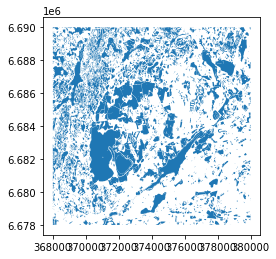

In [12]:
data.plot()

Voilá! As we can see, it is really easy to produce a map out of your Shapefile with geopandas. Geopandas automatically positions your map in a way that it covers the whole extent of your data.

*If you are living in the Helsinki region, you might recognize the shapes plotted on the map!*

## Geometries in Geopandas

Geopandas takes advantage of Shapely's geometric objects. Geometries are stored in a column called *geometry* that is a default column name for
storing geometric information in geopandas.

Let's print the first 5 rows of the column 'geometry':

In [13]:
data['geometry'].head()

0    POLYGON ((379394.248 6689991.936, 379389.790 6...
1    POLYGON ((378980.811 6689359.377, 378983.401 6...
2    POLYGON ((378804.766 6689256.471, 378817.107 6...
3    POLYGON ((379229.695 6685025.111, 379233.366 6...
4    POLYGON ((379825.199 6685096.247, 379829.651 6...
Name: geometry, dtype: geometry

As we can see the `geometry` column contains familiar looking values, namely Shapely `Polygon` -objects. Since the spatial data is stored as Shapely objects, **it is possible to use Shapely methods** when dealing with geometries in geopandas.

Let's have a closer look at the polygons and try to apply some of the Shapely methods we are already familiar with.

Let's start by checking the area of the first polygon in the data:

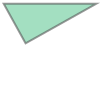

In [14]:
# Access the geometry on the first row of data
data.at[0, "geometry"]

In [15]:
# Print information about the area 
print("Area:", round(data.at[0, "geometry"].area, 0), "square meters")

Area: 76.0 square meters



Let's do the same for the first five rows in the data; 

- Iterate over the GeoDataFrame rows using the `iterrows()` -function that we learned [during the Lesson 6 of the Geo-Python course](https://geo-python.github.io/site/notebooks/L6/pandas/advanced-data-processing-with-pandas.html#Iterating-rows-and-using-self-made-functions-in-Pandas).
- For each row, print the area of the polygon (here, we'll limit the for-loop to a selection of the first five rows):

In [16]:
# Iterate over rows and print the area of a Polygon
for index, row in data[0:5].iterrows():
    
    # Get the area from the shapely-object stored in the geometry-column
    poly_area = row['geometry'].area
    
    # Print info
    print("Polygon area at index {index} is: {area:.0f} square meters".format(index=index, area=poly_area))

Polygon area at index 0 is: 76 square meters
Polygon area at index 1 is: 2652 square meters
Polygon area at index 2 is: 3186 square meters
Polygon area at index 3 is: 13075 square meters
Polygon area at index 4 is: 3981 square meters


As you see from here, all **pandas** methods, such as the `iterrows()` function, are directly available in Geopandas without the need to call pandas separately because Geopandas is an **extension** for pandas. 

In practice, it is not necessary to use the iterrows()-approach to calculate the area for all features. Geodataframes and geoseries have an attribute `area` which we can use for accessing the area for each feature at once: 

In [17]:
data.area

0          76.027392
1        2652.054186
2        3185.649995
3       13075.165279
4        3980.682621
            ...     
4306     2651.800270
4307      376.503380
4308      413.942555
4309     3487.927677
4310     1278.963199
Length: 4311, dtype: float64

Let's next create a new column into our GeoDataFrame where we calculate and store the areas of individual polygons:

In [18]:
# Create a new column called 'area' 
data['area'] = data.area

Check the output:

In [19]:
data['area']

0          76.027392
1        2652.054186
2        3185.649995
3       13075.165279
4        3980.682621
            ...     
4306     2651.800270
4307      376.503380
4308      413.942555
4309     3487.927677
4310     1278.963199
Name: area, Length: 4311, dtype: float64

These values correspond to the ones we saw in previous step when iterating rows.

Let's check what is the `min`, `max` and `mean` of those areas using familiar functions from our previous Pandas lessions.

In [20]:
# Maximum area
round(data['area'].max(), 2)

4084558.15

In [21]:
# Minimum area
round(data['area'].min(), 2)

0.67

In [22]:
# Average area
round(data['area'].mean(), 2)

11522.29

## Writing data into a shapefile

It is possible to export GeoDataFrames into various data formats using the [to_file()](http://geopandas.org/io.html#writing-spatial-data) method. In our case, we want to export subsets of the data into Shapefiles (one file for each feature class).

Let's first select one class (class number `36200`, "Lake water") from the data as a new GeoDataFrame:


In [23]:
# Select a class
selection = data.loc[data["CLASS"]==36200]

Check the selection:

<AxesSubplot:>

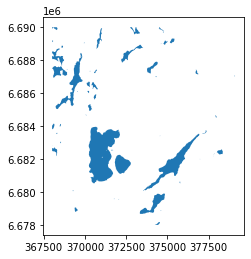

In [24]:
selection.plot()

- write this layer into a new Shapefile using the `gpd.to_file()` -function:

In [25]:
# Create a output path for the data
output_folder = r"L2_data/"
output_fp = os.path.join(output_folder, "Class_36200.shp")

In [26]:
# Write those rows into a new file (the default output file format is Shapefile)
selection.to_file(output_fp)

#### Check your understanding

<div class="alert alert-info">

Read the output Shapefile in a new geodataframe, and check that the data looks ok.
</div>

In [27]:
temp = gpd.read_file(output_fp)

In [28]:
# Check first rows
temp.head()

,GROUP,CLASS,area,geometry
0,64,36200,1318.878221,"POLYGON ((379089.473 6687069.722, 379093.838 6..."
1,64,36200,22918.867073,"POLYGON ((376732.156 6687178.141, 376731.301 6..."
2,64,36200,5759.318345,"POLYGON ((377939.741 6684539.678, 377929.192 6..."
3,64,36200,265899.648379,"POLYGON ((372948.857 6688594.047, 372935.951 6..."
4,64,36200,128221.314258,"POLYGON ((370900.963 6689201.649, 370890.077 6..."


<AxesSubplot:>

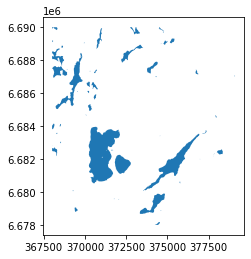

In [29]:
# You can also plot the data for a visual check
temp.plot()

## Grouping the Geodataframe

One really useful function that can be used in Pandas/Geopandas is [groupby()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) which groups data based on values on selected column(s). We saw and used this function already in Lesson 6 of the Geo-Python course. 

Next we will automate the file export task; we will group the data based on column `CLASS` and export a shapefile for each class.

Let's continue with the same input file we already read previously into the variable `data`. We also selected and renamed a subset of the columns.

Check again the first rows of our input data:

In [30]:
data.head()

,GROUP,CLASS,geometry,area
0,64,32421,"POLYGON ((379394.248 6689991.936, 379389.790 6...",76.027392
1,64,32421,"POLYGON ((378980.811 6689359.377, 378983.401 6...",2652.054186
2,64,32421,"POLYGON ((378804.766 6689256.471, 378817.107 6...",3185.649995
3,64,32421,"POLYGON ((379229.695 6685025.111, 379233.366 6...",13075.165279
4,64,32421,"POLYGON ((379825.199 6685096.247, 379829.651 6...",3980.682621


The `CLASS` column in the data contains information about different land use types. With `.unique()` -function we can quickly see all different values in that column:

In [31]:
# Print all unique values in the column
data['CLASS'].unique()

array([32421, 32200, 34300, 34100, 34700, 32500, 32112, 32111, 32611,
       32612, 32800, 32900, 35300, 35412, 35411, 35421, 33000, 33100,
       36200, 36313])

- Now we can use that information to group our data and save all land use types into different layers:

In [32]:
# Group the data by class
grouped = data.groupby('CLASS')

# Let's see what we have
grouped

As we can see, `groupby` -function gives us an object called `DataFrameGroupBy` which is similar to list of keys and values (in a dictionary) that we can iterate over.

Check group keys:

In [33]:
grouped.groups.keys()

dict_keys([32111, 32112, 32200, 32421, 32500, 32611, 32612, 32800, 32900, 33000, 33100, 34100, 34300, 34700, 35300, 35411, 35412, 35421, 36200, 36313])

The group keys are unique values from the column by which we grouped the dataframe.

Check how many rows of data each group has:

In [34]:
# Iterate over the grouped object
for key, group in grouped:

    # Let's check how many rows each group has:
    print('Terrain class:', key)
    print('Number of rows:', len(group), "\n")

Terrain class: 32111
Number of rows: 1 

Terrain class: 32112
Number of rows: 1 

Terrain class: 32200
Number of rows: 2 

Terrain class: 32421
Number of rows: 110 

Terrain class: 32500
Number of rows: 2 

Terrain class: 32611
Number of rows: 257 

Terrain class: 32612
Number of rows: 11 

Terrain class: 32800
Number of rows: 80 

Terrain class: 32900
Number of rows: 28 

Terrain class: 33000
Number of rows: 5 

Terrain class: 33100
Number of rows: 118 

Terrain class: 34100
Number of rows: 3005 

Terrain class: 34300
Number of rows: 1 

Terrain class: 34700
Number of rows: 3 

Terrain class: 35300
Number of rows: 134 

Terrain class: 35411
Number of rows: 35 

Terrain class: 35412
Number of rows: 449 

Terrain class: 35421
Number of rows: 5 

Terrain class: 36200
Number of rows: 56 

Terrain class: 36313
Number of rows: 8 



There are, for example, 56 lake polygons in the input data.

We can also check how the _last_ group looks like (we have the variables in memory from the last iteration of the for-loop):

In [35]:
group.head()

,GROUP,CLASS,geometry,area
4303,64,36313,"POLYGON ((377127.305 6688073.257, 377116.045 6...",9619.307973
4304,64,36313,"POLYGON ((371141.897 6677999.999, 371139.757 6...",25266.167705
4305,64,36313,"POLYGON ((371498.720 6680399.799, 371497.585 6...",364.087680
4306,64,36313,"POLYGON ((375668.607 6682942.062, 375671.489 6...",2651.800270
4307,64,36313,"POLYGON ((368411.063 6679328.990, 368411.424 6...",376.503380


Notice that the index numbers refer to the row numbers in the original data -GeoDataFrame.

Check also the data type of the group:

In [36]:
type(group)

geopandas.geodataframe.GeoDataFrame

As we can see, each set of data are now grouped into separate GeoDataFrames, and we can save them into separate files.

### Saving multiple output files

Let's **export each class into a separate Shapefile**. While doing this, we also want to **create unique filenames for each class**.

When looping over the grouped object, information about the class is stored in the variable `key`, and we can use this information for creating new variable names inside the for-loop. For example, we want to name the shapefile containing lake polygons as "terrain_36200.shp".


<div class="alert alert-info">

**String formatting**
    
There are different approaches for formatting strings in Python. Here are a couple of different ways for putting together file-path names using two variables:

```
basename = "terrain"
key = 36200

# OPTION 1. Concatenating using the `+` operator:
out_fp = basename + "_" + str(key) + ".shp"

# OPTION 2. Positional formatting using `%` operator
out_fp = "%s_%s.shp" %(basename, key)
    
# OPTION 3. Positional formatting using `.format()`
out_fp = "{}_{}.shp".format(basename, key)
```
    
Read more from here: https://pyformat.info/
</div>


Let's now export terrain classes into separate Shapefiles.

- First, create a new folder for the outputs:

In [37]:
# Determine output directory
output_folder = r"L2_data/"

# Create a new folder called 'Results' 
result_folder = os.path.join(output_folder, 'Results')

# Check if the folder exists already
if not os.path.exists(result_folder):
    
    print("Creating a folder for the results..")
    # If it does not exist, create one
    os.makedirs(result_folder)
    
else:
    print("Results folder exists already.")

Creating a folder for the results..


At this point, you can go to the file browser and check that the new folder was created successfully.

- Iterate over groups, create a file name, and save group to file:

In [38]:
# Iterate over the groups
for key, group in grouped:
    # Format the filename 
    output_name = "terrain_{}.shp".format(key)

    # Print information about the process
    print("Saving file", os.path.basename(output_name))

    # Create an output path
    outpath = os.path.join(result_folder, output_name)

    # Export the data
    group.to_file(outpath)

Saving file terrain_32111.shp
Saving file terrain_32112.shp
Saving file terrain_32200.shp
Saving file terrain_32421.shp
Saving file terrain_32500.shp
Saving file terrain_32611.shp
Saving file terrain_32612.shp
Saving file terrain_32800.shp
Saving file terrain_32900.shp
Saving file terrain_33000.shp
Saving file terrain_33100.shp
Saving file terrain_34100.shp
Saving file terrain_34300.shp
Saving file terrain_34700.shp
Saving file terrain_35300.shp
Saving file terrain_35411.shp
Saving file terrain_35412.shp
Saving file terrain_35421.shp
Saving file terrain_36200.shp
Saving file terrain_36313.shp


Excellent! Now we have saved those individual classes into separate Shapefiles and named the file according to the class name. These kind of grouping operations can be really handy when dealing with layers of spatial data. Doing similar process manually would be really laborious and error-prone.

### Extra: save data to csv

We can also extract basic statistics from our geodataframe, and save this information as a text file. 

Let's summarize the total area of each group:

In [39]:
area_info = grouped.area.sum().round()

In [40]:
area_info

CLASS
32111        1834.0
32112        2148.0
32200      105737.0
32421      702073.0
32500      109747.0
32611    13135597.0
32612      107343.0
32800     1465278.0
32900      617209.0
33000      659465.0
33100     3777595.0
34100    12381611.0
34300        1627.0
34700        2786.0
35300     1382940.0
35411      411198.0
35412     4710133.0
35421       67864.0
36200     9986966.0
36313       43459.0
Name: area, dtype: float64

- save area info to csv using pandas:

In [41]:
# Create an output path
area_info.to_csv(os.path.join(result_folder, "terrain_class_areas.csv"), header=True)

## Summary

In this tutorial we introduced the first steps of using geopandas. More specifically you should know how to:

1. Read data from Shapefile using geopandas

2. Access geometry information in a geodataframe

4. Write GeoDataFrame data from Shapefile using geopandas

5. Automate a task to save specific rows from data into Shapefile based on specific key using `groupby()` -function

6. Extra: saving attribute information to a csv file.


 